## **BERT**
![alt text](https://cx3digital.com/wp-content/uploads/2019/11/google-bert.jpg)

### Pre-Training

Thanks to pre-training, BERT is able to learn main information about a language in a general way and it can achieve state of the art on different task just by fine-tuning on some data.

Pre-training consists on training BERT on this two different task:

*  Predict missing words inside given sentence.
*  Predict if a sentence is located after another.

## **APPLICATION**

Starting from original BERT model you can fine-tune it to complete lot's of different task:

*   NER: Generates named entity mapping for each word in the input sequence, e.g. 
*   Sentiment-Analysis: Gives the polarity (positive / negative) of the whole input sequence.
*   Question-Answering: Provided some context and a question refering to the context, it will extract the answer to the question in the context.
*   Summarization: Summarize a given document.
*   Language Translation: translate from language X to language Y the given sentence.
*   ....

And many more task...

The popularity of these model is due to the possibility to adapt a pre-trained model to lot of task with less effort.

## **PURPOSE OF THE NOTEBOOK**

With this tutorial we want to give a visual intuition on how BERT works inside when fine-tuned on sentiment analysis task.

## **USED TOOL**
In this notebook i will use the following package:


*   Transformers
*   NLP
*   BERTVIZ
*   Sklearn

## **CODE REFERENCE**

[Github](https://github.com/DavideStenner)

In [ ]:
#Check which gpu colab gives to me
!nvidia-smi

Thu Jul  2 14:08:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!pip install transformers
!pip install nlp

#Uncomment if you need to install bertviz_repo
# !test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo


In [ ]:
%cd gdrive/My Drive/Colab Notebooks/Progetti Lavoro/Bert_presentation
import sys
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']

In [ ]:
import transformers
from transformers import BertTokenizer, BertForSequenceClassification
from utils import load_dataset_sentiment
from utils import embedding_pipeline, gradient_pipeline, clean_tokens, plot_gradients
from utils import call_html, attention_pipeline
from utils import preprocessing_for_bert, layer_hidden_extractor, outlier_filter, print_hidden
from sklearn.manifold import TSNE
import torch 
from bertviz import head_view
import pandas as pd
from tqdm.notebook import tqdm
import gc
import matplotlib.pyplot as plt

path = '/content/gdrive/My Drive/Progetti Lavoro/bert_finetune'

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_classifier = BertForSequenceClassification.from_pretrained(path, num_labels = 2, output_attentions=True, output_hidden_states=True)


In [ ]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


#Instantiate bert classifier to the gpu
bert_classifier.to(device);

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


# **OUTPUT EXPLANATION**

## **SENTIMENT140**

Sentiment140 is a massive dataset of over 1.600.000 different tweets taken from the web.

Each tweet is classified as popular or not and the main task is to create a model to classify each of them.

Use case for this particular dataset are (as listed on their website):

*   Brand magement
*   Polling
*   Planning a purchase

We will use this dataset with the purpose of extract information from BERT model so first step will be to fine-tune BERT model on this particular dataset.

*For fine-tune notebook refers to bert_training_twitter.

In [ ]:
# Load the dataset
test = load_dataset_sentiment()

## **CONNECTIVITY**

Recent paper suggest the use of the gradient to explain model's output.
The gradient quantifies how much a change in each input dimension would change the predictions. 

In our study case we can give an approximation of which word contribute the most in the model for the prediction.

This method relies on the calculation of connectivity:

$$
\mathrm{connectivity}(t, \tilde{t}) = \left|\left| \frac{\partial y^{\tilde{t}}_{k}}{\partial x^t} \right|\right|_2
$$

With this we can rank each word inside a sentence based on the importance for the model.

*To have knowledge on how each word contribute on prediction you need to use more complicated method as Shap.

<br><br><br><br><br>
Let's try this on different tweets:

Sentence:
 FEELIN' A LI'L UNDER THE WEATHER.. UGH! STOMACH PAAAAAAAAAIN 

Sentiment:
 Negative 




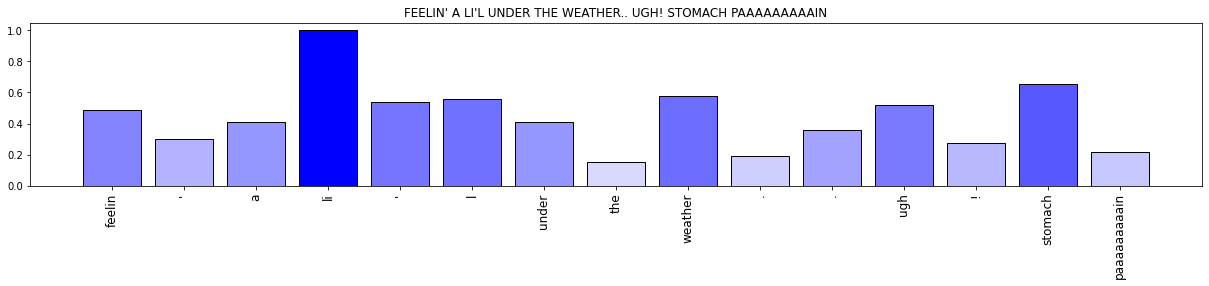

**************************************************************************************************** 


Sentence:
 aww, shame monkey world was a bit on a let down... all that way for one type of monkey and about an hours walk round... 

Sentiment:
 Negative 




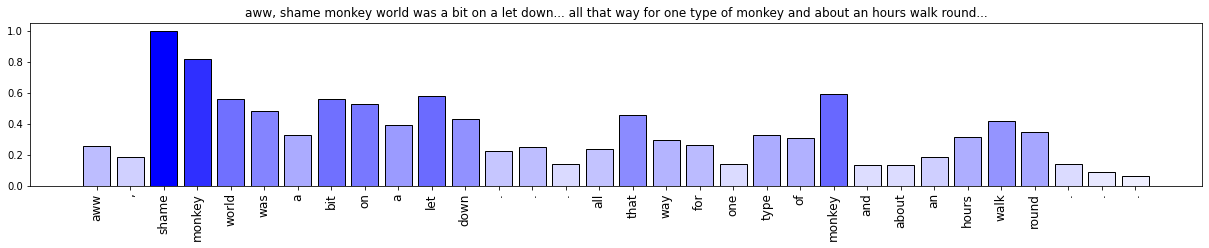

**************************************************************************************************** 


Sentence:
 YAY! OFF TO WHACK SOME DRUMS!!! Gosh, feels so weird w/o me phone 

Sentiment:
 Negative 




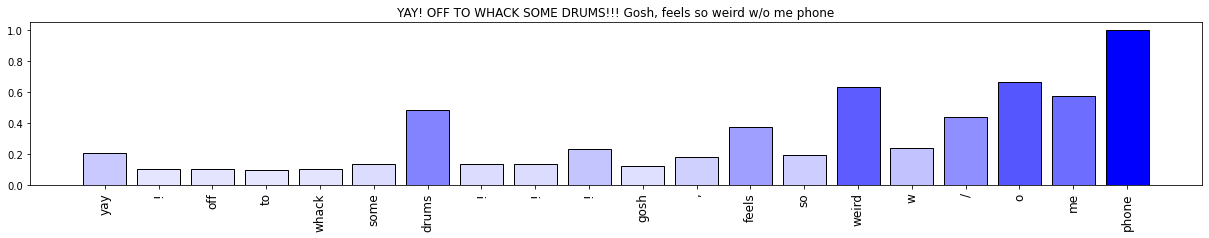

**************************************************************************************************** 


Sentence:
 had an awesome night last night, just wish my camera hadnt of packed up :/ technology eh.. hope everyones having a great weekend? 

Sentiment:
 Positive 




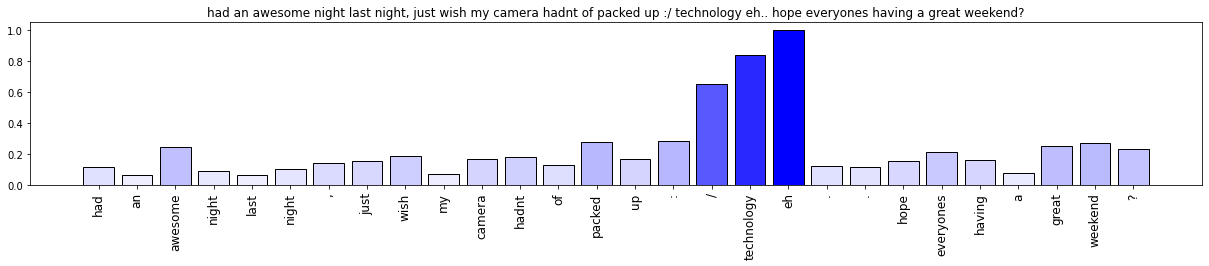

**************************************************************************************************** 


Sentence:
 when you come tour the uk please please please come to scotland we loveeeeeee you hereee &lt;3xxx 

Sentiment:
 Positive 




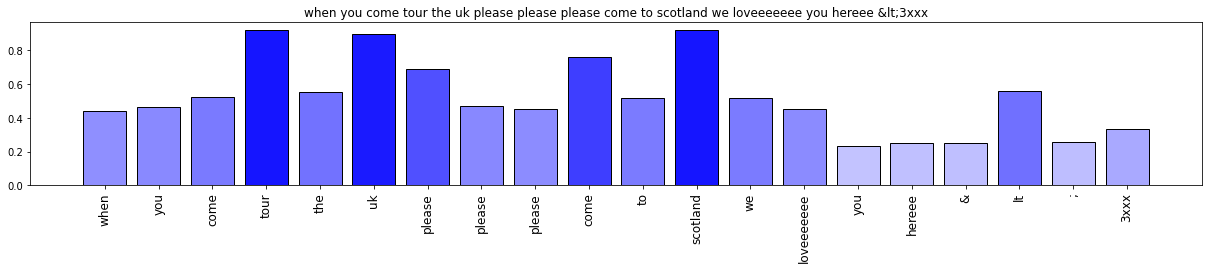

**************************************************************************************************** 


Sentence:
 there are always exceptions to that though. I love my creative mom tweeps 

Sentiment:
 Positive 




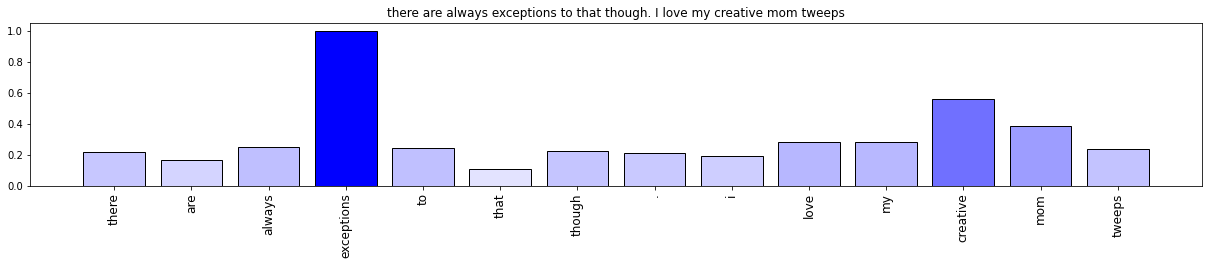

**************************************************************************************************** 




In [ ]:
for positive in range(2):
  for idx in range(3):
  
    #find tweet with more than 50 character that are more explainable
    len_map = [len(x)>50 for x in test.text]


    #Extract sentence and labels from test dataset
    sentence = test.loc[len_map & (test.sentiment == positive)].text.iloc[idx]
    sentiment = test.loc[len_map & (test.sentiment == positive)].sentiment.iloc[idx]
    sentiment_label = 'Positive' if sentiment == 1 else 'Negative'

    b_labels = torch.tensor([sentiment]).cuda()


    print('Sentence:\n', sentence, '\n\nSentiment:\n', sentiment_label,'\n\n')

    #Calculate different embedding used to calculate Saliency
    inputs_embeds, encoded_tokens, token_ids_tensor_one_hot, token_words, token_types = embedding_pipeline(sentence, tokenizer, bert_classifier)

    #Calculate saliency of each token
    gradients = gradient_pipeline(bert_classifier, tokenizer, inputs_embeds, encoded_tokens, b_labels, token_ids_tensor_one_hot)

    #Clean from special token and reduce the wordpiece tokenization
    gradients, tokens, token_types = clean_tokens(gradients, token_words, token_types)

    #Plot Saliency Map
    plot_gradients(tokens, token_types, gradients, sentence)

    #Show the plot
    plt.show()

    print('*'*100, '\n\n')

In [ ]:
#For next phase let's select just one Sentence

#find tweet with more than 50 character that are more explainable
len_map = [len(x)>50 for x in test.text]

idx = 0 #use tweet of this position
positive = 1 #use tweet of this sentiment

#Extract sentence and labels from test dataset
sentence = test.loc[len_map & (test.sentiment == positive)].text.iloc[idx]
sentiment = test.loc[len_map & (test.sentiment == positive)].sentiment.iloc[idx]
sentiment_label = 'Positive' if sentiment == 1 else 'Negative'

b_labels = torch.tensor([sentiment]).cuda()


print('Sentence:\n', sentence, '\n\nSentiment:\n', sentiment_label)

Sentence:
 had an awesome night last night, just wish my camera hadnt of packed up :/ technology eh.. hope everyones having a great weekend? 

Sentiment:
 Positive


# **HOW BERT WORK INSIDE**

We have seen how BERT make some choice, but now we want to have some insight on how this model work inside.

By looking at attention at each layer we can inspect on how much "attention" the model gives to each part of the sentence.

We can see different pattern depending on wich layer we select:



*   Layer 0: It look at each part of the sequence.
*   Layer 2: 
    *   Attention to next word
    *   Attention to identical word
*   Layer 6: Attention to previous word and to delimiters ([SEP], ...)
*   From layer 7-8 it starts to concentrate on most promising part of the sentence.


In [ ]:
#Calculate attention
attention, tokens = attention_pipeline(bert_classifier, tokenizer, sentence)

call_html()

#Represent attention for each layer
head_view(attention, tokens)

Output hidden; open in https://colab.research.google.com to view.

# **WHY IT WORKS IN THIS WAY**

With attention we have seen two main difference on how it behave depending on the choosen layer.

In the first layer it collect general information which can be useful for each kind of problem and in the final layer it creates high level features.

Why it do that? Let's now dive inside hidden activation of each layer.

To visualize this, we will convert a really high dimensional matrix of 150 * 780 to a vector of two components thanks to TSNE.

In [ ]:
n_example = 500
batch_size = 128
num_layer = 13

#Create balanced dataset of 500 negative and 500 positive
tsne_dataset = pd.concat([test.loc[test.sentiment == 0][:n_example], test.loc[test.sentiment == 1][:n_example]], axis = 0).reset_index(drop = True)

#Calculate input and attention mask to pass to bert model
input_ids, attention_mask = preprocessing_for_bert(tsne_dataset.text, tokenizer)

In [ ]:
tsne_list = []

#loop over each layer calculate hiddent state and reduce dimension with t-sne
for layer in tqdm(range(num_layer)):

    #Calculate hiddent state from layer
    hidden_state = layer_hidden_extractor(input_ids, attention_mask, bert_classifier, layer, batch_size, device)

    #Flatten the np array
    hidden_state_flat = hidden_state.reshape((tsne_dataset.shape[0], -1)).cpu().numpy()

    #Calculate tsne over the matrix of hidden state
    X_embedded = TSNE(n_components=2).fit_transform(hidden_state_flat)

    #Clean from outlier
    x_filtered, sentiment_filtered = outlier_filter(X_embedded, tsne_dataset.sentiment)

    tsne_list += [[x_filtered, sentiment_filtered]]

    gc.collect()

By looking at each plot we can clearly see that in initial layer BERT didn't take any kind of decision, but it tries to extract more low information as possible. From layer 6 it begins to sinthetize these information to reach better task represention at layer 12.

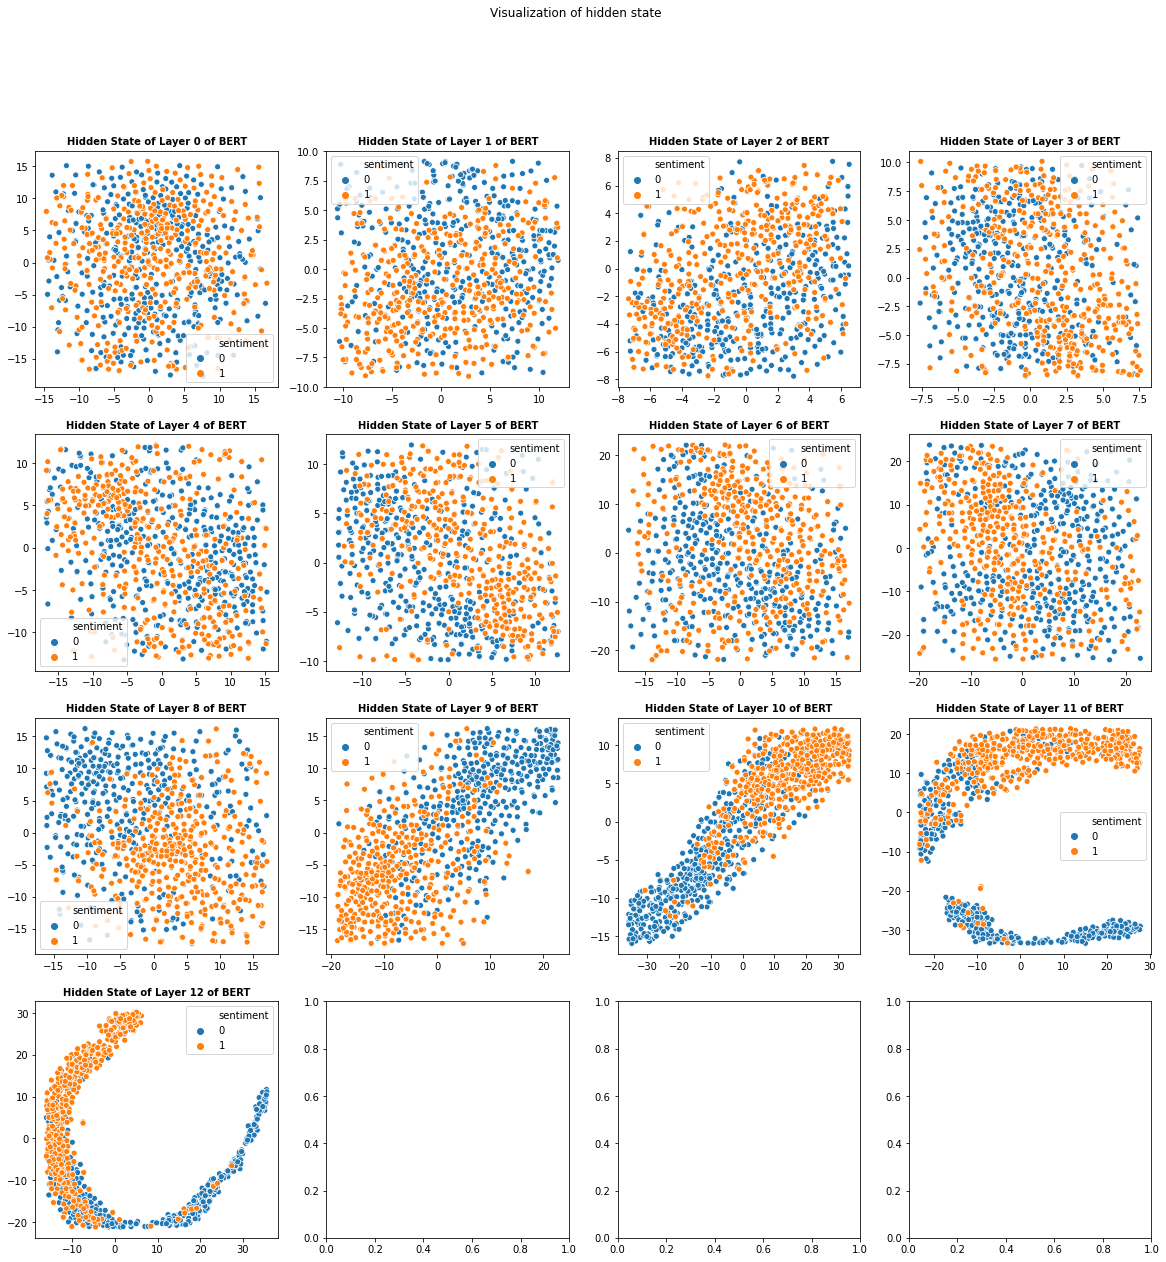

In [ ]:
#Print hidden State
print_hidden(tsne_list)

# **REFERENCE**


*   [TextualHeatMap](https://colab.research.google.com/github/AndreasMadsen/python-textualheatmap/blob/master/notebooks/huggingface_bert_example.ipynb#scrollTo=5tur-G6LngqL)

*   [Output Explanation](https://colab.research.google.com/drive/1tTiOgJ7xvy3sjfiFC9OozbjAX1ho8WN9?usp=sharing)

*   [Sentiment140](http://help.sentiment140.com/for-students)

*   [Fine Tune BERT](https://skimai.com/fine-tuning-bert-for-sentiment-analysis/)

*   [Connectivity](https://distill.pub/2019/memorization-in-rnns/)

*   [Shap](https://github.com/slundberg/shap)

*   [Deconstructing BERT](https://towardsdatascience.com/deconstructing-bert-distilling-6-patterns-from-100-million-parameters-b49113672f77)